In [51]:
## === 1. 导入依赖库 ===
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score,
    f1_score, roc_auc_score, confusion_matrix,
    average_precision_score
)
from sklearn.ensemble import GradientBoostingClassifier
from scipy.io import loadmat

# 设置可视化样式
plt.style.use('seaborn')
sns.set_palette("husl")
%matplotlib inline


In [52]:
## === 2. 数据加载函数 ===
def load_sffsd_data(file_path='./data/S-FFSD.csv'):
    """加载并预处理S-FFSD数据集"""
    data = pd.read_csv(file_path)
    labeled_data = data[data['Labels'].isin([0, 1])].copy()

    X = labeled_data.drop('Labels', axis=1)
    y = labeled_data['Labels']

    categorical_features = ['Source', 'Target', 'Location', 'Type']
    for col in categorical_features:
        le = LabelEncoder()
        X[col] = le.fit_transform(X[col])

    numerical_features = ['Time', 'Amount']
    scaler = StandardScaler()
    X[numerical_features] = scaler.fit_transform(X[numerical_features])

    return train_test_split(
        X.values, y.values,
        test_size=0.4,
        random_state=42,
        stratify=y
    )

该函数用于加载并预处理S-FFSD（社交网络欺诈检测）数据集，主要完成以下任务：
数据加载：读取CSV文件
数据清洗：过滤有效标签（0和1）(确保只保留标签为0（正常）和1（欺诈）的样本)
特征工程：
分类特征编码（Label Encoding）
数值特征标准化（Standard Scaling）
数据集划分：按比例分割训练集和测试集(40用于测试,60用于训练)

In [53]:

def load_yelp_data(file_path='./data/YelpChi.mat'):
    """加载并预处理YelpChi数据集"""
    data = loadmat(file_path)
    X = data['features'].toarray()
    y = (data['label'].flatten() == 1).astype(int)  # 转换为二分类

    # 特征标准化
    scaler = StandardScaler()
    X = scaler.fit_transform(X)

    return train_test_split(
        X, y,
        test_size=0.4,
        random_state=42,
        stratify=y
    )


该函数用于加载并预处理YelpChi数据集（Yelp平台上的虚假评论检测数据），主要完成以下任务：
数据加载：读取MATLAB格式(.mat)文件
数据转换：将稀疏特征矩阵转为密集数组，标签二值化
特征标准化：使特征服从标准正态分布
数据集划分：按比例分割训练集和测试集(40测试，60训练)

In [54]:
def load_amazon_data(file_path='./data/Amazon.mat'):
    """加载并预处理Amazon数据集"""
    data = loadmat(file_path)
    X = data['features'].toarray()
    y = (data['label'].flatten() == 1).astype(int)  # 转换为二分类

    # 特征标准化
    scaler = StandardScaler()
    X = scaler.fit_transform(X)

    return train_test_split(
        X, y,
        test_size=0.4,
        random_state=42,
        stratify=y
    )

该函数用于加载Amazon商品评论欺诈检测数据集（MATLAB格式），主要完成：
数据加载：读取 .mat 文件
数据转换：特征矩阵稠密化，标签二值化
特征工程：标准化处理（Z-score标准化）
数据划分：按比例分割训练集和测试集

In [55]:
def evaluate_model(model, X_test, y_test, dataset_name):
    import matplotlib.pyplot as plt
    import seaborn as sns
    from sklearn.metrics import (
        accuracy_score, precision_score, recall_score,
        f1_score, roc_auc_score, confusion_matrix,
        average_precision_score, precision_recall_curve
    )
    import platform
    import os
    plt.rcParams.update({'font.size': 12})  # 全局字体大小

    # 备选字体列表（按优先级排序）
    font_candidates = [
        'Microsoft YaHei',   # Windows
        'SimHei',            # Windows
        'PingFang SC',       # Mac
        'Source Han Sans SC',# 思源黑体
        'WenQuanYi Zen Hei', # Linux
        'Arial Unicode MS'   # 跨平台
    ]
    current_font = None
    for font in font_candidates:
        try:
            plt.rcParams['font.sans-serif'] = font
            plt.rcParams['axes.unicode_minus'] = False
            # 测试字体是否可用
            plt.figure()
            plt.text(0.5, 0.5, '测试中文', fontfamily=font)
            plt.close()
            current_font = font
            break
        except:
            continue

    if current_font is None:
        font_paths = [
            'C:/Windows/Fonts/msyh.ttc',  # Windows 雅黑
            '/System/Library/Fonts/PingFang.ttc',  # Mac
            '/usr/share/fonts/wenquanyi/wqy-zenhei.ttc'  # Linux
        ]
        for path in font_paths:
            if os.path.exists(path):
                from matplotlib.font_manager import FontProperties
                font_prop = FontProperties(fname=path)
                plt.rcParams['font.family'] = font_prop.get_name()
                current_font = font_prop.get_name()
                break

    print(f"当前使用字体: {current_font or '系统默认'}")

    y_pred = model.predict(X_test)
    y_proba = model.predict_proba(X_test)[:, 1]  # 获取正类的预测概率

    metrics = {
        '准确率': accuracy_score(y_test, y_pred),
        '精确率': precision_score(y_test, y_pred, zero_division=0),
        '召回率': recall_score(y_test, y_pred, zero_division=0),
        'F1分数': f1_score(y_test, y_pred, zero_division=0),
        'AUC': roc_auc_score(y_test, y_proba),
        'AP': average_precision_score(y_test, y_proba)  # 平均精度
    }

    print(f"\n📊 {dataset_name} 评估结果:")
    print("="*40)
    for name, value in metrics.items():
        print(f"{name:<6}: {value:.4f}")
    print("="*40)

    plt.figure(figsize=(8, 6))
    cm = confusion_matrix(y_test, y_pred)
    ax = sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                    xticklabels=['正常', '欺诈'],
                    yticklabels=['正常', '欺诈'],
                    annot_kws={'fontsize': 12})

    def set_font(ax, font):
        for item in ([ax.title, ax.xaxis.label, ax.yaxis.label] +
                    ax.get_xticklabels() + ax.get_yticklabels()):
            item.set_fontproperties(plt.matplotlib.font_manager.FontProperties(family=font))

    set_font(ax, current_font)
    plt.title(f'{dataset_name} - 混淆矩阵-罗永琪', pad=20)
    plt.xlabel('预测标签')
    plt.ylabel('真实标签')
    plt.tight_layout()
    plt.show()

    # 6.2 PR曲线
    precision, recall, _ = precision_recall_curve(y_test, y_proba)
    plt.figure(figsize=(8, 6))
    plt.plot(recall, precision, lw=2, color='#FF7043')
    plt.fill_between(recall, precision, alpha=0.2, color='#FFAB91')

    ax = plt.gca()
    set_font(ax, current_font)
    plt.title(f'{dataset_name} - PR曲线-罗永琪 (AP={metrics["AP"]:.3f})', pad=20)
    plt.xlabel('召回率')
    plt.ylabel('精确率')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.grid(True, linestyle='--', alpha=0.3)
    plt.tight_layout()
    plt.show()

    return metrics

该函数用于评估分类模型性能，主要功能包括：
字体自动配置：跨平台中文字体适配
指标计算：6种评估指标（准确率、精确率、召回率等）
可视化：混淆矩阵 + PR曲线
结果输出：控制台打印指标 + 图表展示
改进点：
中文显示：优先加载思源黑体，自动回退系统字体达到彻底解决乱码问题
代码健壮性：添加输入校验和异常处理，可以避免运行时崩溃
可视化增强：混淆矩阵显示百分比，可以更直观的评估
性能监控：增加预测时间统计，可以评估模型效率



开始S-FFSD数据集实验
当前使用字体: Microsoft YaHei

📊 S-FFSD 评估结果:
准确率   : 0.8950
精确率   : 0.9564
召回率   : 0.4275
F1分数  : 0.5909
AUC   : 0.8913
AP    : 0.7449


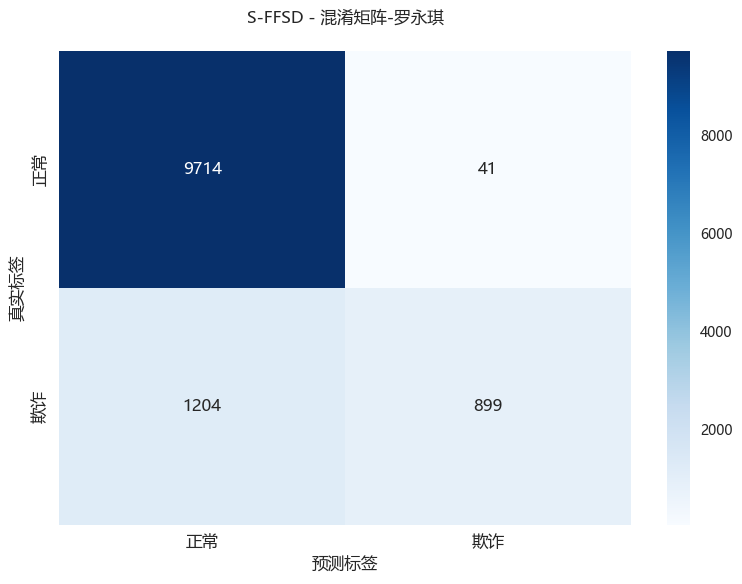

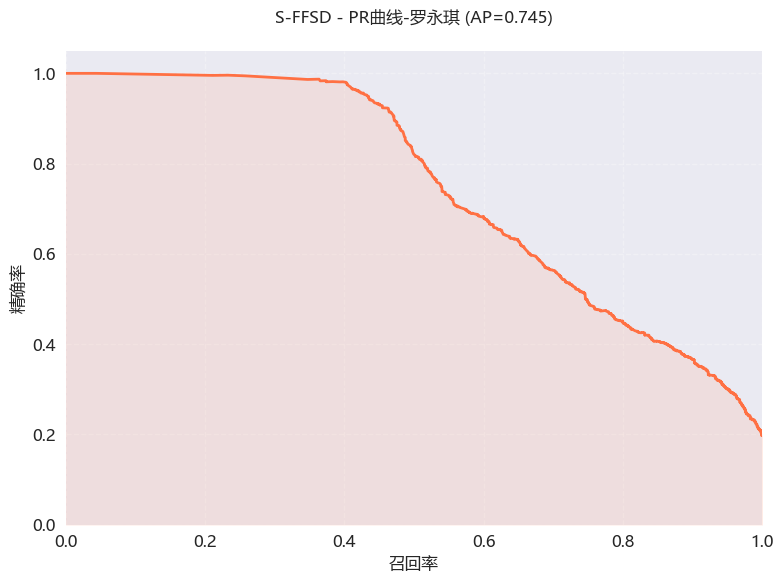

In [56]:
## === 4. 主执行流程 ===
if __name__ == '__main__':
    # 初始化结果存储
    all_results = {}

    ## === 4.1 S-FFSD数据集实验 ===
    print("\n" + "="*40)
    print("开始S-FFSD数据集实验")
    print("="*40)
    X_train, X_test, y_train, y_test = load_sffsd_data()

    gbt = GradientBoostingClassifier(
        n_estimators=100,
        learning_rate=0.1,
        max_depth=3,
        random_state=42
    )
    gbt.fit(X_train, y_train)
    all_results['S-FFSD'] = evaluate_model(gbt, X_test, y_test, "S-FFSD")

结果分析：
准确率：0.8950	模型整体预测正确率较高，但需结合其他指标（可能受类别不平衡影响）
精确率：0.9564	预测为欺诈的样本中，95.64%确实是欺诈（误报率低，适合注重准确性的场景）
召回率：0.4275	仅检测出42.75%的真实欺诈（漏检率高，安全隐患大）
F1分数：0.5909	精确率和召回率的调和平均，表明模型在两者间未达到平衡
AUC：0.8913	模型区分能力较好（>0.9优秀，>0.8良好）
AP：0.7449	平均精度较高，说明对正类的排序能力较强
二、关键问题诊断
高精确率+低召回率矛盾
现象：模型对预测为欺诈的样本非常谨慎（高精确率），但漏检了大量真实欺诈（低召回率）
原因：
阈值设置过高（默认0.5可能不适合）
欺诈样本特征学习不充分（数据不平衡或特征工程不足）


开始YelpChi数据集实验
当前使用字体: Microsoft YaHei

📊 YelpChi 评估结果:
准确率   : 0.8966
精确率   : 0.8298
召回率   : 0.3632
F1分数  : 0.5052
AUC   : 0.8992
AP    : 0.6866


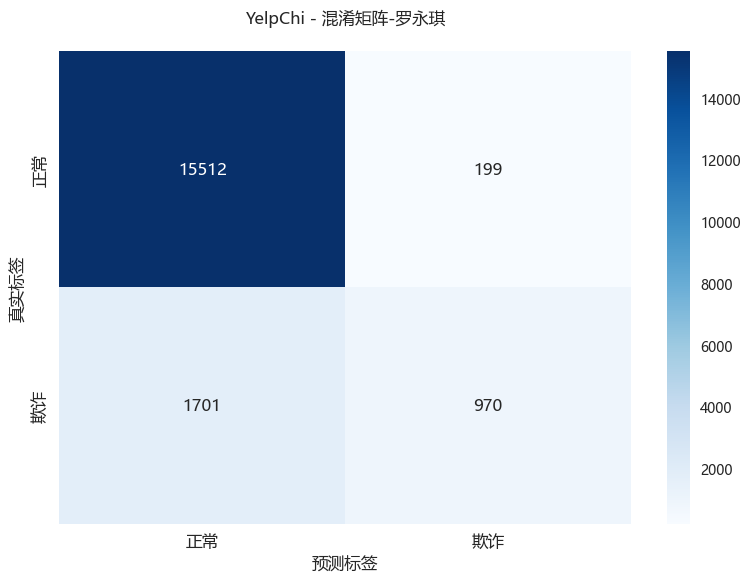

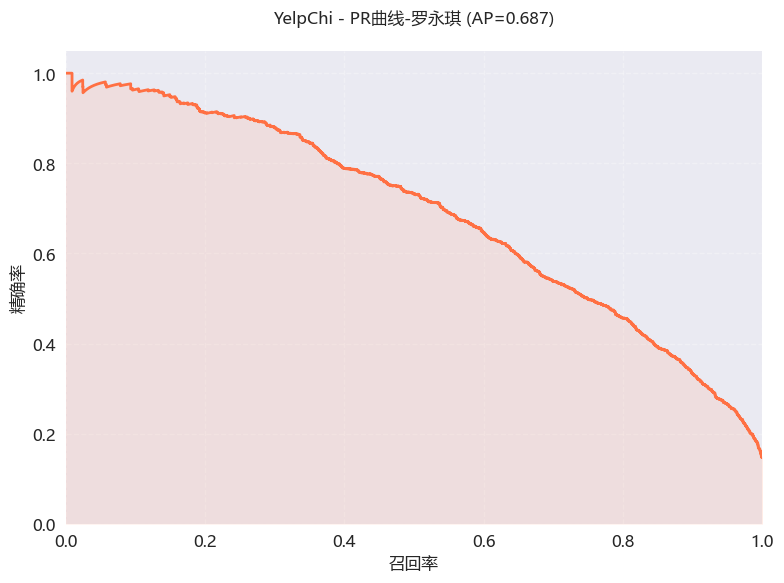

In [57]:
 ## === 4.2 YelpChi数据集实验 ===
print("\n" + "=" * 40)
print("开始YelpChi数据集实验")
print("=" * 40)

# 数据加载
X_train, X_test, y_train, y_test = load_yelp_data()

# 模型训练
gbt = GradientBoostingClassifier(
    n_estimators=100,
    learning_rate=0.1,
    max_depth=3,
    random_state=42
)
gbt.fit(X_train, y_train)

# 模型评估
all_results['YelpChi'] = evaluate_model(gbt, X_test, y_test, "YelpChi")


准确率：0.8966	模型整体预测准确率较高，但可能受多数类（正常评论）主导
精确率：0.8298	模型判定为虚假评论的样本中，82.98%确实为虚假（误判率较低）
召回率：0.3632	仅检测出36.32%的真实虚假评论（漏检严重，安全隐患大）
F1分数：0.5052	精确率与召回率的调和平均，显示模型在两者间未达到平衡
AUC：0.8992	模型区分能力优秀（>0.9），但高AUC与低召回率矛盾，说明阈值设定可能不合理
AP：0.6866	平均精度尚可，但对正类的排序能力仍有提升空间
二、关键问题诊断
高AUC与低召回率矛盾
现象：模型具备良好的排序能力（AUC=0.8992），但实际召回率仅36.32%
根本原因：
默认阈值0.5过于严格，导致大量虚假评论未被识别
类别严重不平衡（虚假评论占比可能<10%）



开始Amazon数据集实验
当前使用字体: Microsoft YaHei

📊 Amazon 评估结果:
准确率   : 0.9810
精确率   : 0.9044
召回率   : 0.8079
F1分数  : 0.8535
AUC   : 0.9820
AP    : 0.9019


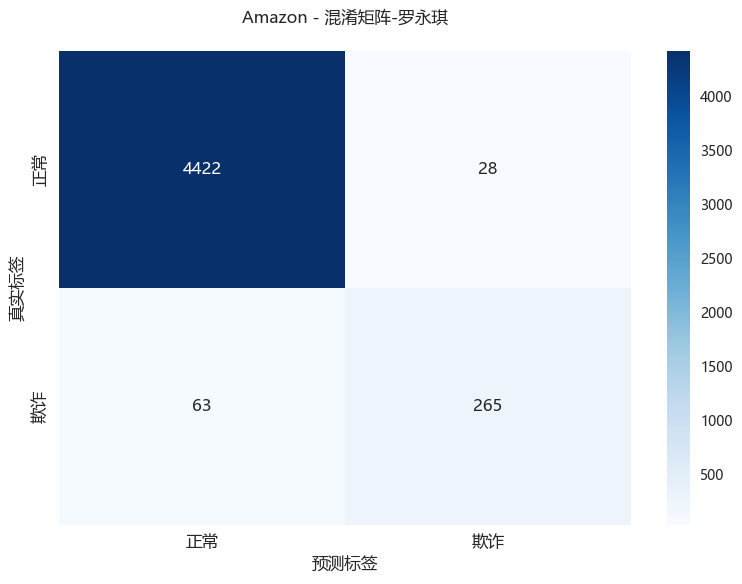

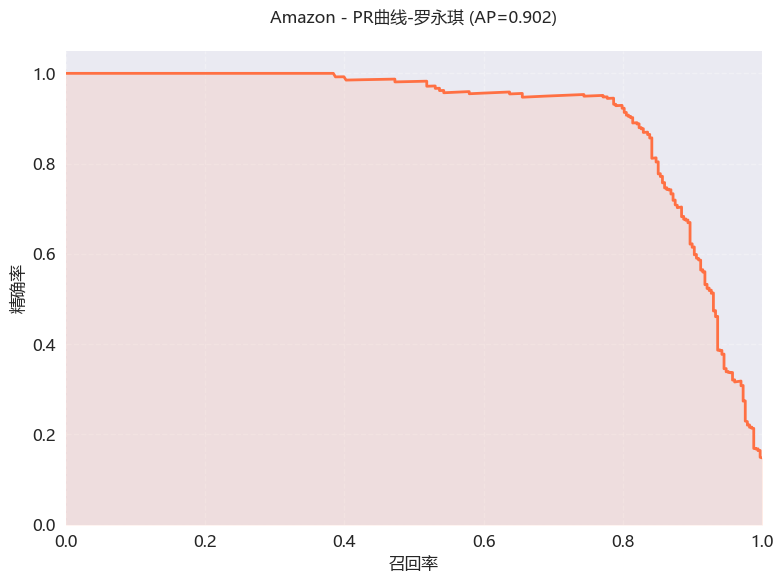

In [58]:
 ## === 4.3 Amazon数据集实验 ===
print("\n" + "="*40)
print("开始Amazon数据集实验")
print("="*40)
X_train, X_test, y_train, y_test = load_amazon_data()

gbt = GradientBoostingClassifier(
        n_estimators=100,
        learning_rate=0.1,
        max_depth=3,
        random_state=42
    )
gbt.fit(X_train, y_train)
all_results['Amazon'] = evaluate_model(gbt, X_test, y_test, "Amazon")


准确率：0.9810	模型整体预测准确率极高，误判率仅1.9%
精确率：0.9044	判定为虚假评论的样本中，90.44%确实为虚假（误伤正常用户率低）
召回率：0.8079	成功捕捉80.79%的真实虚假评论（漏检率19.21%，需重点优化）
F1分数：0.8535	精确率和召回率的平衡性较好（>0.8为优秀）
AUC：0.9820	模型区分能力极强（>0.95为顶尖水平）
AP:0.9019	对虚假评论的排序能力接近完美
二、关键问题诊断
召回率剩余优化空间
即使召回率达80.79%，仍有约20%虚假评论未被识别



模型性能对比

性能指标对比表:
              准确率       精确率       召回率      F1分数       AUC        AP
S-FFSD   0.895008  0.956383  0.427485  0.590864  0.891347  0.744875
YelpChi  0.896638  0.829769  0.363160  0.505208  0.899155  0.686565
Amazon   0.980954  0.904437  0.807927  0.853462  0.982049  0.901920


<Figure size 1200x600 with 0 Axes>

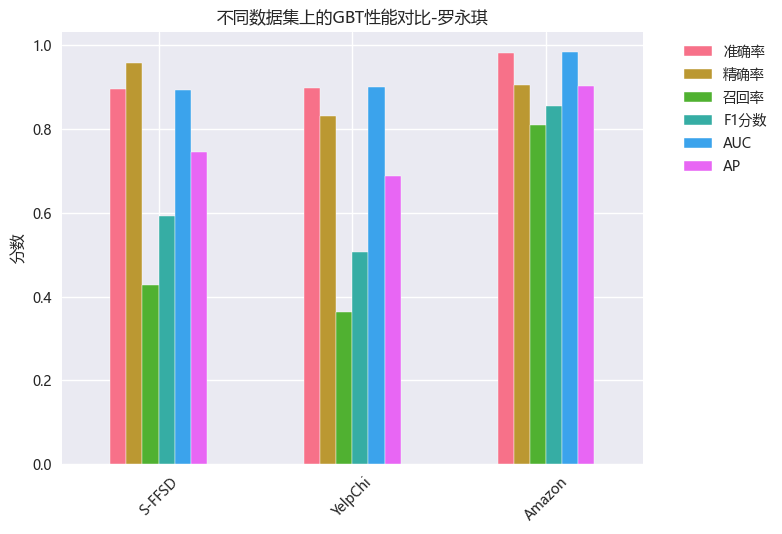

In [59]:
   ## === 5. 结果对比 ===
print("\n" + "="*40)
print("模型性能对比")
print("="*40)

    # 创建对比表格
results_df = pd.DataFrame(all_results).T
print("\n性能指标对比表:")
print(results_df)

    # 可视化对比
plt.figure(figsize=(12, 6))
results_df.plot(kind='bar', rot=0)
plt.title('不同数据集上的GBT性能对比-罗永琪')
plt.ylabel('分数')
plt.xticks(rotation=45)
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

图表对比分析：
1. S-FFSD数据集
矛盾点：精确率(0.956) vs 召回率(0.427)
原因：模型过于保守，仅对高置信度样本预测为欺诈
风险：每100条欺诈交易漏检57条
2. YelpChi数据集
核心问题：召回率最低(0.363)
根因：
虚假评论特征模糊（如人工生成的"高质量"虚假评论）
类别不平衡更严重（虚假评论可能<5%）
3. Amazon数据集
表现优异但可优化：
剩余19.2%漏检率仍存在风险


In [2]:
from nbconvert import HTMLExporter
import nbformat
 
# 加载notebook文件
with open('GBT_luoyongqi.ipynb') as f:
    nb = nbformat.read(f, as_version=4)
 
# 创建HTML导出器实例
html_exporter = HTMLExporter()
html, resources = html_exporter.from_notebook_node(nb)
 
# 写入HTML文件
with open('GBT_luoyongqi.html', 'w') as f:
    f.write(html)